In [1]:
from __future__ import division
import scipy.io
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind
from mne.stats import fdr_correction

### 1. Load .mat files into dataframe

In [36]:
roi = 'bf' # 'bf', 'tf'

In [37]:
reals = glob.glob('dyads_MEA_data/D*')

#### Real dyads

In [38]:
# Initialise empty dataframe
Real = pd.DataFrame()

# loop over all .mat files
for f in glob.glob('dyads_MEA_data/D*/*.mat'):
    
    # load file
    mat = scipy.io.loadmat(f)
    # extract filename from path
    filename = f.split('/')[1]
    # create dataframe with mRsq
    fileframe = pd.DataFrame(mat[roi]['mRsq'][0][0])
    fileframe.rename(columns={0:'mRsq'}, inplace=True)
    fileframe['Frequency'] = mat[roi]['per'][0][0].T
    # add dyad number and task (extracted from filename) as columns
    fileframe['dyad'] = filename.split('_')[0]
    fileframe['task'] = filename.split('_')[2] + '_' + filename.split('_')[3]
    
    # concatenate fileframe to total dataframe
    Real = pd.concat([Real,fileframe])

# drop the index (=Frequency) and add as column
Real.reset_index(drop=True,inplace=True)

# Add pair column
Real['Pair'] = 'Real'

#### Pseudo pairs

In [39]:
# Initialise empty dataframe
Pseudo = pd.DataFrame()

# loop over all .mat files
for f in glob.glob('dyads_MEA_data/P*/*.mat'):
    
    # load file
    mat = scipy.io.loadmat(f)
    # extract filename from path
    filename = f.split('/')[1]
    # create dataframe with mRsq
    fileframe = pd.DataFrame(mat[roi]['mRsq'][0][0])
    fileframe.rename(columns={0:'mRsq'}, inplace=True)
    fileframe['Frequency'] = mat[roi]['per'][0][0].T
    # add dyad number and task (extracted from filename) as columns
    fileframe['dyad'] = filename.split('_')[1]
    fileframe['task'] = filename.split('_')[3] + '_' + filename.split('_')[4]
    
    # concatenate fileframe to total dataframe
    Pseudo = pd.concat([Pseudo,fileframe])

# drop the index (=Frequency) and add as column
Pseudo.reset_index(drop=True,inplace=True)

# Add pair column
Pseudo['Pair'] = 'Pseudo'

#### Combine dataframes

In [40]:
Total = pd.concat([Real, Pseudo], ignore_index=False)

#### Recode dyads to group

In [41]:
Total['Group'] = pd.np.where(Total['dyad'].isin(['D13','D14','D15','D16','D17',
                                                'D18','D19','D20','D23','D26']),'TD',
                             pd.np.where(Total['dyad'].isin(['D1','D2','D3','D4','D5',
                                                            'D6','D7','D8','D29','D30']),'ASD','Mixed'))

#### Calculate Frequency and log

In [42]:
Total['Frequency'] = pd.np.round(1./Total['Frequency'],3)

In [43]:
Total['Frequency (log)'] = pd.np.log2(Total['Frequency'])

#### Delete _neworder from task name

In [44]:
Total['task'] = Total['task'].str.replace('_neworder','')

#### View dataframe

In [45]:
Total.head()

,mRsq,Frequency,dyad,task,Pair,Group,Frequency (log)
0,0.155863,12.100,D6,island,Real,ASD,3.596935
1,0.136621,11.421,D6,island,Real,ASD,3.513617
2,0.120687,10.780,D6,island,Real,ASD,3.430285
3,0.108075,10.175,D6,island,Real,ASD,3.346957
4,0.097620,9.604,D6,island,Real,ASD,3.263635


### 2. Analysis

#### 2.1. Average across tasks

In [46]:
task_average = (
    Total.groupby(['dyad','Frequency (log)','Pair'])
         .agg({'mRsq':'mean','Group':'last','Frequency':'last'})
         .reset_index(drop=False)
)

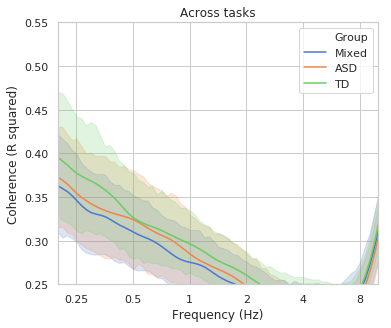

In [47]:
sns.set(font_scale=1, style='whitegrid', font= 'DejaVu Sans')
sns.set_palette('muted')

sns.lineplot(x="Frequency (log)", 
             y="mRsq",
             hue='Group',  
             hue_order=['Mixed','ASD','TD'],
             data=task_average)

plt.xlim(pd.np.log2([0.2,10]))
plt.ylim(0.25,0.55)
plt.xticks(pd.np.log2([0.25, 0.5, 1, 2, 4, 8]), [0.25, 0.5, 1, 2, 4, 8])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence (R squared)')
plt.title('Across tasks')
plt.tight_layout()
fig =plt.gcf()
fig.set_size_inches(5.5, 5)
fig.savefig('results/coherence_task_average_' + roi + '.pdf')

#### 2.2. Individual tasks

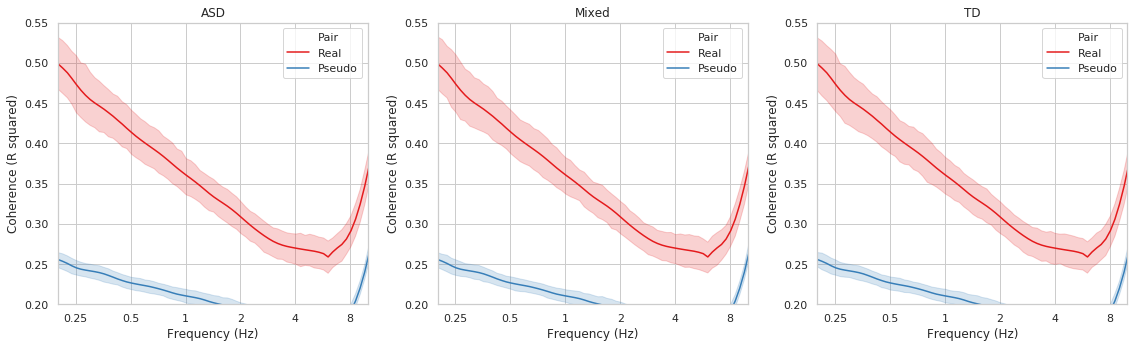

In [48]:
sns.set(font_scale=1, style='whitegrid', font= 'DejaVu Sans')
sns.set_palette('Set1')

for idx, group_of_interest in enumerate(Total.Group.unique()):
    plt.subplot(1,3,idx+1)
    sns.lineplot(x="Frequency (log)", 
                 y="mRsq",
                 hue='Pair',
                 hue_order=['Real','Pseudo'],
                 data=task_average)#Total[Total['Group']==group_of_interest])

    plt.xlim(pd.np.log2([0.2,10]))
    plt.ylim(0.2,0.55)
    plt.xticks(pd.np.log2([0.25, 0.5, 1, 2, 4, 8]), [0.25, 0.5, 1, 2, 4, 8])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Coherence (R squared)')
    plt.title(group_of_interest)

fig = plt.gcf()
fig.set_size_inches(16,5)
plt.tight_layout()
fig.savefig('results/coherence_real_pseudo_' + roi + '.pdf')

#### 2.3 Statistical analysis (task average)

In [ ]:
stats_df = task_average[task_average['Frequency'].between(0.2,8)]

In [ ]:
stats_avg = (
    stats_df.groupby(['Group','Frequency'])
            .agg({'mRsq': ['mean'],
                  'Frequency (log)': 'last'})
            .reset_index(drop=False)
)

In [ ]:
# initialise lists
freqs = []
ts = []
ps = []
comps = []

comparison = [['TD','ASD'],
              ['TD','Mixed'],
              ['ASD','Mixed']]

# loop over comparison
for c in comparison:
    
    # loop over freq
    for freq in stats_df['Frequency'].unique():
    
        # calculate t-test
        t, p = ttest_ind(stats_df[(stats_df['Frequency']==freq) & (stats_df['Group']==c[0])].mRsq,
                     stats_df[(stats_df['Frequency']==freq) & (stats_df['Group']==c[1])].mRsq, 
                     equal_var=False)

        # add to lists
        ts.append(t)
        ps.append(p)
        freqs.append(freq)
        comps.append(c[0] + ' vs ' + c[1])
    
# list to dataframe
stats = pd.DataFrame({'freq': freqs,
                      't': ts,
                      'p': ps,
                      'Comparison': comps})

stats['p_fdr'] = fdr_correction(alpha=0.05,pvals=stats.p)[1]

In [ ]:
sns.lineplot(x='freq', 
             y='t', 
             hue='Comparison', 
             hue_order=['TD vs Mixed', 'ASD vs Mixed', 'TD vs ASD'],
             data=stats)
plt.xlabel('Frequency (Hz)')
plt.ylabel('t')
plt.title('Effect sizes');
plt.hlines(y=0, xmin=0, xmax=8)